<a href="https://colab.research.google.com/github/niikun/DL_for_health_care/blob/main/Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab2

データの準備、基本的な統計の計算、簡単なモデルの構築は、データサイエンスの実践に欠かせないステップです。このラボでは、PyTorchを使ってパイプライン全体を試してみます。具体的には、まずPyTorchでのDNNの実装に慣れる。次に、DNNを使って、前回の診察の診断コードに基づく死亡率予測を行う。

目次

非線形性
PytorchによるDNN
割り当て
前処理
DNNモデル
このラボの内容の一部は、Dive into Deep LearningとOfficial PyTorch Tutoriから引用しています。

In [95]:
import os
import csv
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
import matplotlib.pyplot as plt

In [96]:
# set seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

# 1. Nonlinearity
これまでは線形回帰モデルを実装していた。しかし、線形モデルは時にうまくいかないことがあります。

これは、線形性が単調性という弱い仮定を意味するからです。つまり、特徴量が増加すると（対応する重みが正の場合）モデルの出力が常に増加するか、（対応する重みが負の場合）モデルの出力が常に減少するかのどちらかでなければなりません。

しかし、単調性に反する例は簡単に思いつく。例えば、体温に基づいて死亡確率を予測したいとします。体温が37℃以上の個体では、体温が高いほどリスクが高いことを示す。しかし、体温が37℃以下の人は、体温が高いほどリスクが低いことを示す！この場合も、巧妙な特徴工学で問題を解決できるかもしれない。すなわち、37℃からの距離を特徴として使うのである。

しかし、診断に基づいて死亡率を予測したい場合はどうだろう。多くの領域知識を必要とする特徴工学を実行するのは非常に難しい。



## 1.2 Incorporating Hidden Layers
線形モデルのこのような制限を克服し、1つ以上の隠れ層を組み込むことで、より一般的なクラスの関数を扱うことができる。これを行う最も簡単な方法は、完全に接続された層をいくつも重ねることだ。各層は、出力を生成するまで、その上の層にフィード・インする。最初の 𝐿−1
  層を表現とし、最後の層を線形予測器と考えることができる。このアーキテクチャは一般に多層パーセプトロンと呼ばれ、しばしば MLP と略されます。以下に、MLP を図式化します。  
  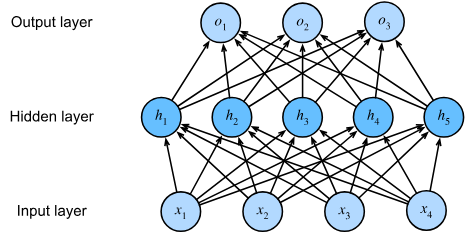

  Formally, this MLP can be expressed as:  

$$
𝐇=𝐗𝐖^{(1)}+𝐛^{(1)},  
𝐎=𝐇𝐖^{(2)}+𝐛^{(2)}
$$

## 1.3 From Linear to Nonlinear
上記のモデルでは、私たちは悩みの割に何も得られないことに驚くかもしれない！理由は簡単だ。上の隠れユニットは入力のアフィン関数で与えられ、出力は隠れユニットのアフィン関数にすぎない。アフィン関数のアフィン関数は、それ自体がアフィン関数なのだ。さらに、私たちの線形モデルはすでにどんなアフィン関数でも表現することができた。つまり  
$$
𝐎=(𝐗𝐖^{(1)}+𝐛^{(1)})𝐖^{(2)}+𝐛^{(2)}=𝐗𝐖^{(1)}𝐖^{(2)}+𝐛^{(1)}𝐖^{(2)}+𝐛^{(2)}=𝐗𝐖+𝐛.
$$
多層アーキテクチャの可能性を実現するためには、もう一つ重要な要素が必要である。
  であり、アフィン変換後の各隠れユニットに適用される。活性化関数の出力（例えば$σ$(⋅)
 )を活性化と呼びます。一般的に、活性化関数が導入されると、MLP を線形モデルに変換することはできなくなります：
 $$
 𝐇=𝜎(𝐗𝐖(1)+𝐛(1)),  
 $$
 $$
 𝐎=𝐇𝐖(2)+𝐛(2).
 $$
 活性化関数は、加重和を計算し、さらにバイアスを加えることによって、ニューロンを活性化すべきかどうかを決定する。活性化関数は入力信号を出力に変換する微分可能な演算子であり、ほとんどの演算子は非線形性を付加する。活性化関数は深層学習の基本であるため、いくつかの一般的な活性化関数について簡単にサーベイしておこう。

**ReLU Function**

実装が簡単で、様々な予測タスクで優れた性能を発揮することから、最も一般的な選択は、整流線形ユニット（ReLU）である。ReLUは非常に単純な非線形変換を提供します。
 :
$$
ReLU(𝑥)=max(𝑥,0).
 $$
直感的に理解するために、関数をプロットしてみましょう。ご覧のように、活性化関数は区分線形です。

Text(0, 0.5, 'relu(x)')

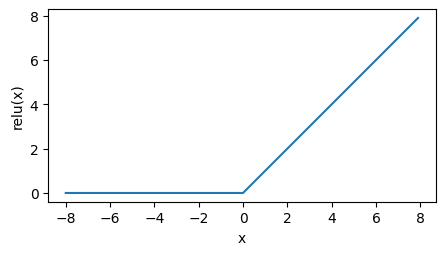

In [97]:
x = torch.arange(-8.0, 8.0, 0.1)
y = torch.relu(x)
plt.figure(figsize=(5, 2.5))
plt.plot(x.detach(), y.detach())
plt.xlabel('x')
plt.ylabel('relu(x)')

### Exercise 1
Plot the Tanh Function.

Text(0, 0.5, 'tanh(x)')

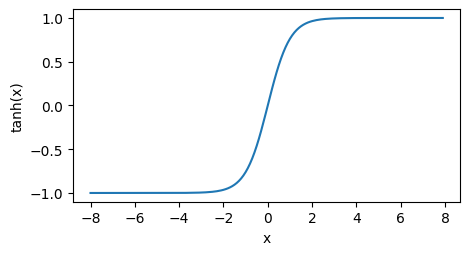

In [98]:
x = torch.arange(-8.0, 8.0, 0.1)
y = torch.tanh(x)
# your code here
# raise NotImplementedError
plt.figure(figsize=(5, 2.5))
plt.plot(x.detach(), y.detach())
plt.xlabel('x')
plt.ylabel('tanh(x)')

# 2. DNN Model
プログラミングの観点からは、DNNモデルはクラスで表現される。そのサブクラスは、入力を出力に変換する順伝播関数を定義し、必要なパラメータを格納する必要があります。いくつかのサブクラスはパラメータを全く必要としないことに注意。最後に、モデルは勾配を計算するためのバックプロパゲーション関数を持たなければなりません。幸運なことに、独自のモデルを定義するときに自動微分によって提供されるビハインド・ザ・シーンのマジックによって、我々はパラメータと順伝播関数だけを気にすればよい。

以下のコードは、256ユニットとReLU活性化を持つ1つの完全連結隠れ層と、それに続く10ユニットの完全連結出力層（活性化関数なし）を持つネットワークを生成する。

In [99]:
net = nn.Sequential(nn.Linear(20,256),nn.ReLU(),nn.Linear(256,10))

In [100]:
X = torch.rand(2,20)

In [101]:
print(X,X.shape)

tensor([[0.6163, 0.9143, 0.5020, 0.3720, 0.4863, 0.7831, 0.9288, 0.3749, 0.7664,
         0.7786, 0.9467, 0.8582, 0.0870, 0.0869, 0.0851, 0.8142, 0.2461, 0.7762,
         0.4256, 0.2940],
        [0.8762, 0.4034, 0.2302, 0.4234, 0.1820, 0.0186, 0.4124, 0.4718, 0.2150,
         0.9432, 0.3883, 0.3730, 0.8962, 0.5556, 0.3824, 0.6150, 0.0482, 0.9916,
         0.6319, 0.6758]]) torch.Size([2, 20])


In [102]:
net(X)

tensor([[ 0.1677,  0.2065, -0.2746, -0.1013,  0.2246,  0.1783,  0.0501, -0.0086,
         -0.0600, -0.2115],
        [ 0.1484,  0.1665, -0.2590, -0.1304,  0.0505,  0.1214, -0.1044, -0.0971,
         -0.0822, -0.1282]], grad_fn=<AddmmBackward0>)

この例では、`nn.Sequential`をインスタンス化し、引数としてレイヤーを実行する順番に渡すことでモデルを構築しています。要するに、`nn.Sequential`はPyTorchでモデルを表現するクラスであるModuleの特別な種類を定義しています。`nn.Sequential`は構成されるModuleの順序付きリストを保持します。完全に接続された2つのレイヤーはそれぞれLinearクラスのインスタンスであり、それ自体がModuleのサブクラスであることに注意してください。順伝播（forward）関数も驚くほどシンプルで、リスト内の各ブロックを連結し、それぞれの出力を次のブロックの入力として渡す。これまでは、`net(X)`という構文を使ってモデルを呼び出し、その出力を得ていた。これは実際には`net.__call__(X)`の略記にすぎない。

**A Custom Model**  
モデルがどのように機能するのかを直感的に理解する最も簡単な方法は、自分自身でモデルを実装することでしょう。独自のカスタムモデルを実装する前に、各モデルが提供しなければならない基本的な機能を簡単にまとめておきます：

入力データを順伝播関数の引数として取り込む。
順伝播関数が値を返すことによって出力を生成する。出力は入力と異なる形状を持つ可能性があることに注意。
入力に対する出力の勾配を計算する。通常、これは自動的に行われる。
順伝播計算を実行するために必要なパラメータを格納し、アクセスできるようにする。
必要に応じてモデル・パラメータを初期化する。
以下のスニペットでは、256個の隠れユニットを持つ1つの隠れ層と、10次元の出力層を持つMLPに対応するモデルをゼロからコード化します。以下の MLP クラスは、モデルを表すクラスを継承していることに注意してください。ここでは、親クラスの関数に大きく依存し、独自のコンストラクタ（Python では __init__ 関数）と順伝播関数のみを用意します。

In [103]:
class MLP(nn.Module):
    # Declare a layer with model parameters. Here, we declare two fully
    # connected layers
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(20,256)
        self.out = nn.Linear(256,10)

    def forward(self,X):
        return self.out(F.relu(self.hidden(X)))


まず、順伝播関数に注目しよう。この関数は X を入力とし、活性化関数を適用した隠れ表現を計算し、その対数を出力します。

コンストラクタでMLPのレイヤーをインスタンス化し、その後、順伝播関数を呼び出すたびにこれらのレイヤーを呼び出します。いくつかの重要な点に注意してください。まず、カスタマイズした `__init__` 関数は `super().__init__()` によって親クラスの `__init__` 関数を呼び出します。次に、完全に接続された2つのレイヤーをインスタンス化し、`self.hidden`と`self.out`に代入します。新しい演算子を実装しない限り、バックプロパゲーション関数やパラメータの初期化について心配する必要はない。これらの関数はシステムが自動的に生成する。これを試してみよう。

In [104]:
net = MLP()
net(X)

tensor([[ 1.7738e-01,  1.2829e-01,  6.3749e-02,  4.8818e-02,  7.5031e-05,
          1.4179e-01, -4.1864e-02, -9.4340e-02,  6.6383e-02,  1.5124e-01],
        [ 8.7345e-02,  8.7090e-02,  1.6082e-01, -6.5498e-02,  4.6025e-02,
         -6.3114e-03,  4.5823e-02, -6.2648e-02,  3.2010e-02,  1.0640e-01]],
       grad_fn=<AddmmBackward0>)

### Exercise 2 [20 points]  
Implement the following model architecture.  

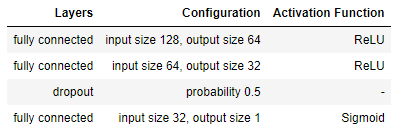

In [105]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(128,64)
        self.fc2 = nn.Linear(64,32)
        self.dropout = nn.Dropout(0.5)
        self.fc3 = nn.Linear(32,1)

    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.sigmoid(self.fc3(x))

        return x

In [106]:
'''
AUTOGRADER CELL. DO NOT MODIFY THIS.
'''

model = Net()

assert model.fc1.in_features == 128
assert model.fc1.out_features == 64
assert model.fc2.in_features == 64
assert model.fc2.out_features == 32
assert model.fc3.in_features == 32
assert model.fc3.out_features == 1

x = torch.rand(2, 128)
output = model.forward(x)
assert output.shape == (2, 1), "Net() is wrong!"

# Assignment  
この課題では、MIMIC-IIIの臨床データを生の入力として使用し、死亡率予測を行います。


## Preprocessing  
MIMIC-IIIは、2001年から2012年の間にBeth Israel Deaconess Medical Centerの重症治療室に入院した40,000人以上の患者に関する非識別化された健康関連データからなる、自由に利用できる大規模なデータベースである。

ライセンスの問題から、我々はMIMIC-III Demoデータセットを使用する。

目的は、各入院の診断コード（モデル入力）と死亡率情報（モデル出力）を抽出することである。

### Patient  
このテーブルは、データベース内の各 subject_id、すなわち1人の患者を定義する。

In [107]:
DATA_PATH = "/content/drive/MyDrive/coursera/Deep Learning for Healthcare/"
patients = pd.read_csv(os.path.join(f'{DATA_PATH}/PATIENTS.csv'))
print(patients.shape)
patients

(100, 8)


,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag
0,9467,10006,F,2094-03-05 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,1
1,9472,10011,F,2090-06-05 00:00:00,2126-08-28 00:00:00,2126-08-28 00:00:00,NaN,1
2,9474,10013,F,2038-09-03 00:00:00,2125-10-07 00:00:00,2125-10-07 00:00:00,2125-10-07 00:00:00,1
3,9478,10017,F,2075-09-21 00:00:00,2152-09-12 00:00:00,NaN,2152-09-12 00:00:00,1
4,9479,10019,M,2114-06-20 00:00:00,2163-05-15 00:00:00,2163-05-15 00:00:00,2163-05-15 00:00:00,1
...,...,...,...,...,...,...,...,...
95,31838,44083,M,2057-11-15 00:00:00,2114-02-20 00:00:00,2114-02-20 00:00:00,2114-02-20 00:00:00,1
96,31853,44154,M,1878-05-14 00:00:00,2178-05-15 00:00:00,2178-05-15 00:00:00,2178-05-15 00:00:00,1
97,31867,44212,F,2078-06-16 00:00:00,2124-01-29 00:00:00,NaN,2124-01-29 00:00:00,1
98,31870,44222,M,2107-06-27 00:00:00,2182-08-03 00:00:00,2182-08-03 00:00:00,NaN,1


In [108]:
patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   row_id       100 non-null    int64 
 1   subject_id   100 non-null    int64 
 2   gender       100 non-null    object
 3   dob          100 non-null    object
 4   dod          100 non-null    object
 5   dod_hosp     70 non-null     object
 6   dod_ssn      77 non-null     object
 7   expire_flag  100 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 6.4+ KB


In [109]:
patients.describe()

,row_id,subject_id,expire_flag
count,100.000000,100.000000,100.0
mean,20452.580000,26162.330000,1.0
std,10982.043163,16201.834705,0.0
min,9467.000000,10006.000000,1.0
25%,9526.500000,10068.500000,1.0
50%,20209.000000,25128.000000,1.0
75%,31391.250000,42276.500000,1.0
max,31872.000000,44228.000000,1.0


#### Convert date-of-birth to date
これまでのdobは文字列でした。これを日付に変換することで、患者の年齢を簡単に計算することができます。

In [110]:
patients.loc[:,"dob"] = pd.to_datetime(patients.loc[:,"dob"]).dt.date

#### Prepare mortality label
dod_hospが有効であることは、患者が個々の入院中またはICU滞在中に死亡したことを意味する（ラベル1）。

In [111]:
patients["dod_hosp"].apply(lambda x:0 if pd.isnull(x) else 1)

0     1
1     1
2     1
3     0
4     1
     ..
95    1
96    1
97    0
98    1
99    1
Name: dod_hosp, Length: 100, dtype: int64

In [112]:
patients["dod_hosp"].notnull().astype(int)

0     1
1     1
2     1
3     0
4     1
     ..
95    1
96    1
97    0
98    1
99    1
Name: dod_hosp, Length: 100, dtype: int64

In [113]:
patients['mortality'] = patients['dod_hosp'].apply(lambda x: 0 if x != x else 1)

In [114]:
patients = patients[['subject_id', 'gender', 'dob', 'mortality']]
print(patients.shape)
patients.head()

(100, 4)


,subject_id,gender,dob,mortality
0,10006,F,2094-03-05,1
1,10011,F,2090-06-05,1
2,10013,F,2038-09-03,1
3,10017,F,2075-09-21,0
4,10019,M,2114-06-20,1


#### Admission
このテーブルは、患者の入院、hamm_id を定義する。

In [115]:
admissions = pd.read_csv(os.path.join(f'{DATA_PATH}/ADMISSIONS.csv'))
print(admissions.shape)
admissions.head()

(129, 19)


,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,12258,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,2164-10-23 16:43:00,2164-10-23 23:00:00,SEPSIS,0,1
1,12263,10011,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,2126-08-28 18:59:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,HEPATITIS B,1,1
2,12265,10013,165520,2125-10-04 23:36:00,2125-10-07 15:13:00,2125-10-07 15:13:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,NaN,UNKNOWN/NOT SPECIFIED,NaN,NaN,SEPSIS,1,1
3,12269,10017,199207,2149-05-26 17:19:00,2149-06-03 18:42:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,2149-05-26 12:08:00,2149-05-26 19:45:00,HUMERAL FRACTURE,0,1
4,12270,10019,177759,2163-05-14 20:43:00,2163-05-15 12:00:00,2163-05-15 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,NaN,NaN,ALCOHOLIC HEPATITIS,1,1


#### Convert admittime and dischtime to date
dobと同様、日付に変換することで、患者の年齢を簡単に計算することができる。

In [116]:
admissions['admittime'] = pd.to_datetime(admissions['admittime']).dt.date
admissions['dischtime'] = pd.to_datetime(admissions['dischtime']).dt.date

#### Exclude other columns

In [117]:
admissions = admissions[['subject_id', 'hadm_id', 'admittime', 'dischtime']]
print(admissions.shape)
admissions.head()

(129, 4)


,subject_id,hadm_id,admittime,dischtime
0,10006,142345,2164-10-23,2164-11-01
1,10011,105331,2126-08-14,2126-08-28
2,10013,165520,2125-10-04,2125-10-07
3,10017,199207,2149-05-26,2149-06-03
4,10019,177759,2163-05-14,2163-05-15


#### Merge patient and admission info
subject_idで患者テーブルと入院テーブルをマージします。

In [118]:
patients_admissions = pd.merge(admissions, patients, how='inner', on='subject_id')
print(patients_admissions.shape)
patients_admissions.head()

(129, 7)


,subject_id,hadm_id,admittime,dischtime,gender,dob,mortality
0,10006,142345,2164-10-23,2164-11-01,F,2094-03-05,1
1,10011,105331,2126-08-14,2126-08-28,F,2090-06-05,1
2,10013,165520,2125-10-04,2125-10-07,F,2038-09-03,1
3,10017,199207,2149-05-26,2149-06-03,F,2075-09-21,0
4,10019,177759,2163-05-14,2163-05-15,M,2114-06-20,1


In [119]:
# calculate admission age
patients_admissions['age'] = patients_admissions.apply(lambda x: (x['admittime'] - x['dob']).days // 365.25, axis=1)
# for patient with age > 89, set it to 89
patients_admissions['age'] = patients_admissions['age'].apply(lambda x: 89 if x > 89 else x)

#### Diagnosis code
この表には、患者のICD診断、特にICD-9診断が含まれている。

In [120]:
# set of valid admission ids
valid_adm_ids = set(patients_admissions.hadm_id)

In [121]:
def convert_to_3digit_icd9(dxStr):
    """ convert icd9 to 3-digit version """
    if dxStr.startswith('E'):
        if len(dxStr) > 4:
            return dxStr[:4]
        else:
            return dxStr
    else:
        if len(dxStr) > 3:
            return dxStr[:3]
        else:
            return dxStr

In [122]:
diagnosis_icd = pd.read_csv(os.path.join(f'{DATA_PATH}/DIAGNOSES_ICD.csv'))
print(diagnosis_icd.shape)
diagnosis_icd.head()

(1761, 5)


,row_id,subject_id,hadm_id,seq_num,icd9_code
0,112344,10006,142345,1,99591
1,112345,10006,142345,2,99662
2,112346,10006,142345,3,5672
3,112347,10006,142345,4,40391
4,112348,10006,142345,5,42731


In [123]:
for col in diagnosis_icd.columns:
    print(diagnosis_icd[col].value_counts())

row_id
112344    1
388136    1
388147    1
388146    1
388145    1
         ..
113430    1
113429    1
113428    1
113427    1
397677    1
Name: count, Length: 1761, dtype: int64
subject_id
41976    266
10088     57
40310     53
42346     41
41795     39
        ... 
10089      5
10098      5
10064      4
10035      4
10046      3
Name: count, Length: 100, dtype: int64
hadm_id
153826    37
186361    36
101361    31
126949    27
149469    24
          ..
133283     5
110244     4
125157     4
111761     4
133110     3
Name: count, Length: 129, dtype: int64
seq_num
1     129
2     129
3     129
4     128
5     125
6     119
7     116
8     111
9     104
10     84
11     80
12     69
13     64
14     60
15     52
16     46
17     41
18     32
19     26
20     22
21     21
22     17
23     14
24      8
25      4
26      4
27      4
30      3
31      3
29      3
28      3
32      2
33      2
34      2
35      2
36      2
37      1
Name: count, dtype: int64
icd9_code
4019     53
42731    48


In [124]:
print("Original shape:", diagnosis_icd.shape)

Original shape: (1761, 5)


#### Drop invalid admissions

In [125]:
print("# of rows with invalid admissions:", np.count_nonzero(diagnosis_icd['hadm_id'].isin(valid_adm_ids) == False))
diagnosis_icd = diagnosis_icd[diagnosis_icd['hadm_id'].isin(valid_adm_ids)].reset_index(drop=True)
print("Rows with invalid admissions are dropped! Shape:", diagnosis_icd.shape)

# of rows with invalid admissions: 0
Rows with invalid admissions are dropped! Shape: (1761, 5)


#### Convert to ICD9 3-digit
我々は非常に限られたデータしか持っていないので、ICD9を3桁版に変換すれば、学習プロセスが容易になる（例えば、表現がずっと小さくなる）。

In [126]:
diagnosis_icd['icd9_3digit'] = diagnosis_icd['icd9_code'].apply(lambda x: convert_to_3digit_icd9(x))
diagnosis_icd.head()

,row_id,subject_id,hadm_id,seq_num,icd9_code,icd9_3digit
0,112344,10006,142345,1,99591,995
1,112345,10006,142345,2,99662,996
2,112346,10006,142345,3,5672,567
3,112347,10006,142345,4,40391,403
4,112348,10006,142345,5,42731,427


#### Group by admission


In [127]:
diagnosis_icd = diagnosis_icd.groupby('hadm_id')['icd9_3digit'].unique().reset_index()
print(diagnosis_icd.shape)
diagnosis_icd.head()

(129, 2)


,hadm_id,icd9_3digit
0,100375,"[038, 599, 584, 276, 785, 428, 995]"
1,100969,"[434, 348, 518, 507, 427, 250, 401, 443, 496, ..."
2,101361,"[997, 518, 511, V46, 584, 348, 996, 995, 038, ..."
3,102203,"[572, 584, 789, 261, 276, 571, 537, 303, V49]"
4,103379,"[038, 785, 486, 008, 197, 156, 451, 995, 244, ..."


#### Merge patient, admission, and diagnosis code info
Merge all three tables together on hadm_id.

In [128]:
df = pd.merge(patients_admissions, diagnosis_icd, how='inner', on='hadm_id')
df

,subject_id,hadm_id,admittime,dischtime,gender,dob,mortality,age,icd9_3digit
0,10006,142345,2164-10-23,2164-11-01,F,2094-03-05,1,70.0,"[995, 996, 567, 403, 427, 428, 424, 287, 038, ..."
1,10011,105331,2126-08-14,2126-08-28,F,2090-06-05,1,36.0,"[570, 070, 304, 287, 276]"
2,10013,165520,2125-10-04,2125-10-07,F,2038-09-03,1,87.0,"[038, 410, 785, 486, 427, 202, 424, 458, 272]"
3,10017,199207,2149-05-26,2149-06-03,F,2075-09-21,0,73.0,"[812, 492, 802, 998, 415, 285, 486, E885, 250,..."
4,10019,177759,2163-05-14,2163-05-15,M,2114-06-20,1,48.0,"[038, 518, 577, 303, 578, 584, 284, 572, 785, ..."
...,...,...,...,...,...,...,...,...,...
124,44083,198330,2112-05-28,2112-06-07,M,2057-11-15,1,54.0,"[423, 511, 285, V10, 401]"
125,44154,174245,2178-05-14,2178-05-15,M,1878-05-14,1,89.0,"[038, 518, 507, 995, 427, 724, 362, 716, 454]"
126,44212,163189,2123-11-24,2123-12-30,F,2078-06-16,0,45.0,"[038, 785, 584, 482, 518, 599, 348, 287, 276, ..."
127,44222,192189,2180-07-19,2180-07-20,M,2107-06-27,1,73.0,"[427, 584, E942, 414, 403, 585, 250, 357, 272,..."


In [129]:
df = df.sort_values(['subject_id', 'admittime'], ascending=True).reset_index(drop=True)
df.head()

,subject_id,hadm_id,admittime,dischtime,gender,dob,mortality,age,icd9_3digit
0,10006,142345,2164-10-23,2164-11-01,F,2094-03-05,1,70.0,"[995, 996, 567, 403, 427, 428, 424, 287, 038, ..."
1,10011,105331,2126-08-14,2126-08-28,F,2090-06-05,1,36.0,"[570, 070, 304, 287, 276]"
2,10013,165520,2125-10-04,2125-10-07,F,2038-09-03,1,87.0,"[038, 410, 785, 486, 427, 202, 424, 458, 272]"
3,10017,199207,2149-05-26,2149-06-03,F,2075-09-21,0,73.0,"[812, 492, 802, 998, 415, 285, 486, E885, 250,..."
4,10019,177759,2163-05-14,2163-05-15,M,2114-06-20,1,48.0,"[038, 518, 577, 303, 578, 584, 284, 572, 785, ..."


In [130]:
df = df[['subject_id', 'gender', 'hadm_id', 'age', 'mortality', 'icd9_3digit']]
df = df.rename(columns={'icd9_3digit': 'icd9'})
df

,subject_id,gender,hadm_id,age,mortality,icd9
0,10006,F,142345,70.0,1,"[995, 996, 567, 403, 427, 428, 424, 287, 038, ..."
1,10011,F,105331,36.0,1,"[570, 070, 304, 287, 276]"
2,10013,F,165520,87.0,1,"[038, 410, 785, 486, 427, 202, 424, 458, 272]"
3,10017,F,199207,73.0,0,"[812, 492, 802, 998, 415, 285, 486, E885, 250,..."
4,10019,M,177759,48.0,1,"[038, 518, 577, 303, 578, 584, 284, 572, 785, ..."
...,...,...,...,...,...,...
124,44083,M,198330,54.0,1,"[423, 511, 285, V10, 401]"
125,44154,M,174245,89.0,1,"[038, 518, 507, 995, 427, 724, 362, 716, 454]"
126,44212,F,163189,45.0,0,"[038, 785, 584, 482, 518, 599, 348, 287, 276, ..."
127,44222,M,192189,73.0,1,"[427, 584, E942, 414, 403, 585, 250, 357, 272,..."


Statistics¶
Calculate some statistics.

In [131]:
def mean_max_min_std(series):
    print(f"mean: {np.mean(series):.1f}, min: {np.min(series):.1f}, max: {np.max(series):.1f}, std: {np.std(series):.1f}")

In [132]:
print("Total # of patients:", len(df.groupby('subject_id')), '\n')

print("Total # of admissions:", len(df.groupby('hadm_id')), '\n')

print(df.groupby(['subject_id', 'gender']).size().groupby('gender').size(), '\n')

print("age:")
mean_max_min_std(df.age)
print()

print("# of diagnosis codes:")
mean_max_min_std(df['icd9'].dropna().apply(lambda x: len(x)))
print()

print("# of admissions:")
mean_max_min_std(df.groupby('subject_id')['hadm_id'].apply(lambda x: len(x.unique())))
print()

print(df.groupby(['subject_id', 'mortality']).size().groupby('mortality').size(), '\n')

Total # of patients: 100 

Total # of admissions: 129 

gender
F    55
M    45
dtype: int64 

age:
mean: 69.8, min: 17.0, max: 89.0, std: 16.3

# of diagnosis codes:
mean: 12.6, min: 3.0, max: 31.0, std: 5.6

# of admissions:
mean: 1.3, min: 1.0, max: 15.0, std: 1.4

mortality
0    30
1    70
dtype: int64 



#### Convert diagnosis code to index
コードを機械的に認識できるようにするには、文字列からインデックスに変換する必要がある。例えば、コード'008'はインデックス0に変換される。

このようにして、入院患者内の診断コードを1ホットのベクトルで表現することができ、このベクトルを直接モデルに入力することができる。


In [133]:
all_codes = list(set([j for i in df.icd9.to_list() for j in i]))
all_codes.sort()
all_codes[:10]

['008', '038', '041', '054', '070', '112', '117', '150', '151', '153']

In [134]:
TOTAL_NUM_CODES = len(all_codes)
TOTAL_NUM_CODES

275

In [135]:
code2idx = {}
for idx, code in enumerate(all_codes):
    code2idx[code] = idx

code2idx

{'008': 0,
 '038': 1,
 '041': 2,
 '054': 3,
 '070': 4,
 '112': 5,
 '117': 6,
 '150': 7,
 '151': 8,
 '153': 9,
 '154': 10,
 '156': 11,
 '157': 12,
 '162': 13,
 '189': 14,
 '193': 15,
 '196': 16,
 '197': 17,
 '198': 18,
 '200': 19,
 '202': 20,
 '203': 21,
 '204': 22,
 '205': 23,
 '227': 24,
 '238': 25,
 '242': 26,
 '244': 27,
 '250': 28,
 '251': 29,
 '253': 30,
 '255': 31,
 '261': 32,
 '263': 33,
 '268': 34,
 '272': 35,
 '273': 36,
 '274': 37,
 '275': 38,
 '276': 39,
 '277': 40,
 '278': 41,
 '280': 42,
 '281': 43,
 '283': 44,
 '284': 45,
 '285': 46,
 '286': 47,
 '287': 48,
 '288': 49,
 '289': 50,
 '290': 51,
 '291': 52,
 '292': 53,
 '293': 54,
 '294': 55,
 '295': 56,
 '296': 57,
 '298': 58,
 '300': 59,
 '303': 60,
 '304': 61,
 '305': 62,
 '311': 63,
 '319': 64,
 '327': 65,
 '331': 66,
 '332': 67,
 '333': 68,
 '336': 69,
 '338': 70,
 '340': 71,
 '342': 72,
 '344': 73,
 '345': 74,
 '348': 75,
 '349': 76,
 '351': 77,
 '356': 78,
 '357': 79,
 '362': 80,
 '365': 81,
 '366': 82,
 '370': 83,
 '

In [136]:
df['icd9'] = df.icd9.apply(lambda x: [code2idx[i] for i in x])
df['icd9']

0      [229, 230, 155, 92, 104, 105, 101, 48, 1, 200,...
1                                   [158, 4, 61, 48, 39]
2               [1, 93, 200, 127, 104, 20, 101, 121, 35]
3      [212, 130, 208, 232, 98, 46, 127, 242, 28, 239...
4      [1, 139, 164, 60, 165, 167, 45, 160, 200, 229,...
                             ...                        
124                              [100, 136, 46, 258, 90]
125           [1, 139, 134, 229, 104, 188, 80, 185, 119]
126    [1, 200, 167, 125, 139, 174, 75, 48, 39, 151, ...
127    [104, 167, 253, 97, 92, 168, 28, 79, 35, 67, 188]
128           [1, 200, 127, 0, 17, 11, 116, 229, 27, 46]
Name: icd9, Length: 129, dtype: object

#### Convert diagnoiss index to str and join by ';'

In [137]:
df['icd9'] = df['icd9'].apply(lambda x: ';'.join([str(i) for i in x]))
df.head()

,subject_id,gender,hadm_id,age,mortality,icd9
0,10006,F,142345,70.0,1,229;230;155;92;104;105;101;48;1;200;240;257;15...
1,10011,F,105331,36.0,1,158;4;61;48;39
2,10013,F,165520,87.0,1,1;93;200;127;104;20;101;121;35
3,10017,F,199207,73.0,0,212;130;208;232;98;46;127;242;28;239;259;35;90
4,10019,M,177759,48.0,1,1;139;164;60;165;167;45;160;200;229;159;90;131...


#### Train/Test split
データを80％のトレーニング・セットと20％のテスト・セットに分ける。通常は、訓練／検証／テストの分割を行うべきである。しかし、データが非常に限られているため、デモンストレーションのためにトレーニング/テスト分割を行います。

In [138]:
all_patients = list(df.subject_id.unique().tolist())
random.shuffle(all_patients)
train_ids = all_patients[:int(len(all_patients) * 0.8)]
test_ids = all_patients[int(len(all_patients) * 0.8):]

In [139]:
print("# of train:", len(train_ids))
print("# of test:", len(test_ids))

# of train: 80
# of test: 20


In [140]:
df_train = df[df['subject_id'].isin(train_ids)].reset_index(drop=True)
df_test = df[df['subject_id'].isin(test_ids)].reset_index(drop=True)

In [142]:
DELIVERABLE_PATH = "/content/drive/MyDrive/coursera/Deep Learning for Healthcare/"
df_train.to_csv(os.path.join(f'{DELIVERABLE_PATH}/train.csv'), index=False)
df_test.to_csv(os.path.join(f'{DELIVERABLE_PATH}/test.csv'), index=False)

## DNN model
前回のラボでは、線形回帰モデルを実装したが、これはレイヤーが1つしかない。データ量の増加と計算能力の向上のおかげで、ディープ・ラーニング・ネットワークは何十層、何百層という大規模なものになる傾向がある。

前の問題でやったように、重み行列だけを使ってこのようなディープ・ネットワークを構築することもできますが、一般的に実装は非常に面倒で困難です。PyTorchには大規模なニューラルネットワークを効率的に構築するための素晴らしいモジュールnnがあります。

In [143]:
# two helper functions


def read_csv(filename):
    """ reading csv from filename """
    data = []
    with open(filename, "r") as file:
        csv_reader = csv.DictReader(file, delimiter=',')
        for row in csv_reader:
            data.append(row)
    header = list(data[0].keys())
    return header, data


def to_one_hot(label, num_class):
    """ convert to one hot label """
    one_hot_label = [0] * num_class
    for i in label:
        one_hot_label[i] = 1
    return one_hot_label

### Custom Dataset
まず、PyTorchのDatasetクラスを使ってカスタムデータセットを実装します。これは前のラボのdata_iter()関数に似ています。

入力として診断コードを使い、出力として死亡率を使います。

1人の患者が複数の入院をすることがありますが、DNNは時間的な情報を捉えることができないので、このラボでは最後の入院の診断コードのみを使用することに注意してください。

次のラボでは、全入院シーケンスを活用し、時間的依存性をモデル化できるCNNとRNNを試す。

In [144]:
from torch.utils.data import Dataset


class CustomDataset(Dataset):

    def __init__(self, split):
        # read the csv
        self._df = pd.read_csv(f'{DELIVERABLE_PATH}/{split}.csv')
        # split diagnosis code index by ';' and convert it to integer
        self._df.icd9 = self._df.icd9.apply(lambda x: [int(i) for i in x.split(';')])
        # build data dict
        self._build_data_dict()
        # a list of subject ids
        self._subj_ids = list(self._data.keys())
        # sort the subject ids to maintain a fixed order
        self._subj_ids.sort()

    def _build_data_dict(self):
        """
        build SUBJECT_ID to ADMISSION dict
            - subject_id
                - icd9: a list of ICD9 code index
                - mortality: 0/1 morality label
        """
        dict_data = {}
        df = self._df.groupby('subject_id').agg({'mortality': lambda x: x.iloc[0], 'icd9': list}).reset_index()
        for idx, row in df.iterrows():
            subj_id = row.subject_id
            dict_data[subj_id] = {}
            dict_data[subj_id]['icd9'] = row.icd9
            dict_data[subj_id]['mortality'] = row.mortality
        self._data = dict_data

    def __len__(self):
        """ return the number of samples (i.e. patients). """
        return len(self._subj_ids)

    def __getitem__(self, index):
        """ generates one sample of data. """
        # obtain the subject id
        subj_id = self._subj_ids[index]
        # obtain the data dict by subject id
        data = self._data[subj_id]
        # convert last admission's diagnosis code index to one hot
        x = torch.tensor(to_one_hot(data['icd9'][-1], TOTAL_NUM_CODES), dtype=torch.float32)
        # mortality label
        y = torch.tensor(data['mortality'], dtype=torch.float32)
        return x, y

In [145]:
train_dataset = CustomDataset('train')
test_dataset = CustomDataset('test')
print('Size of training set:', len(train_dataset))
print('Size of testing set:', len(test_dataset))

Size of training set: 80
Size of testing set: 20


In [146]:
x, y = train_dataset[0]
print(f'Example x (shape {x.shape}):\n', x)
print(f'Example y:\n', y)

Example x (shape torch.Size([275])):
 tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
  

In [147]:
from torch.utils.data import DataLoader

# how many samples per batch to load
batch_size = 8

# prepare dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print("# of train batches:", len(train_loader))
print("# of test batches:", len(test_loader))

# of train batches: 10
# of test batches: 3


### Bulid Model
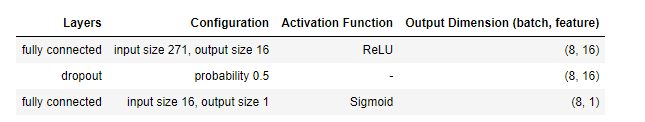

In [ ]:
"""
TODO: Build the MLP shown above.
HINT: Consider using `nn.Linear`, `nn.Dropout`, `F.relu`, `torch.sigmoid`.
"""

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # DO NOT change the names
        self.fc1 = nn.Linear(271,16)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(16,1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.sigmoid(self.fc2(x))

        return x

In [148]:
model = Net()

### Losses in PyTorch
前回のラボでは、ゼロから損失関数を実装しました。

まず、PyTorchで損失を計算する方法を見てみましょう。PyTorchはnn.moduleを通して、バイナリクロスエントロピー損失(nn.BCELoss)のような損失を提供しています。この損失は通常criterionに割り当てられます。

前編で述べたように、死亡率予測のような分類問題では、死亡確率を予測するためにシグモイド関数を使います。シグモイド出力では、損失としてバイナリ・クロス・エントロピーを使いたい。実際に損失を計算するには、まず基準を定義し、次にネットワークの出力と正しいラベルを渡します。

In [149]:
criterion = nn.BCELoss()

### Optimizer in PyTorch
Optimizer can update the weights with the gradients. In the previous lab, we implement the sgd optimizer from scratch. We can get these from PyTorch's optim package. For example we can use stochastic gradient descent with `optim.SGD`.

In [151]:
"""
TODO: Define the optimizer (SGD) with learning rate 0.01, assign it to `optimizer`.

REFERENCE: https://pytorch.org/docs/stable/optim.html
"""
from torch import optim
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [154]:
from sklearn.metrics import *

#input: Y_score,Y_pred,Y_true
#output: accuracy, auc, precision, recall, f1-score
def classification_metrics(Y_score, Y_pred, Y_true):
    acc, auc, precision, recall, f1score = accuracy_score(Y_true, Y_pred), \
                                           roc_auc_score(Y_true, Y_score), \
                                           precision_score(Y_true, Y_pred), \
                                           recall_score(Y_true, Y_pred), \
                                           f1_score(Y_true, Y_pred)
    return acc, auc, precision, recall, f1score


#input: model, loader
def evaluate(model, loader):
    model.eval()
    all_y_true = torch.LongTensor()
    all_y_pred = torch.LongTensor()
    all_y_score = torch.FloatTensor()
    for x, y in loader:
        # pass the input through the model
        y_hat = model(x)
        # convert shape from [batch size, 1] to [batch size]
        y_hat = y_hat.view(y_hat.shape[0])
        """
        TODO: obtain the predicted class (0, 1) by comparing y_hat against 0.5,
        assign the predicted class to y_pred.
        """
        y_pred = y_hat.where(y_hat > 0.5, 1, 0)
        # your code here

        all_y_true = torch.cat((all_y_true, y.to('cpu')), dim=0)
        all_y_pred = torch.cat((all_y_pred,  y_pred.to('cpu')), dim=0)
        all_y_score = torch.cat((all_y_score,  y_hat.to('cpu')), dim=0)

    acc, auc, precision, recall, f1 = classification_metrics(all_y_score.detach().numpy(),
                                                             all_y_pred.detach().numpy(),
                                                             all_y_true.detach().numpy())
    print(f"acc: {acc:.3f}, auc: {auc:.3f}, precision: {precision:.3f}, recall: {recall:.3f}, f1: {f1:.3f}")
    return acc, auc, precision, recall, f1